# Open Access Hubを利用してSentinelの衛星データをAPI経由で取得

- APIのユーザーガイド

https://scihub.copernicus.eu/userguide/

- ユーザー登録画面

https://scihub.copernicus.eu/dhus/#/self-registration

In [76]:
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
import folium

from geojson import Polygon
import json

# 前準備

## 取得したいエリアの座標を取得する

In [77]:
# 座標を算出するためのツール
from IPython.display import HTML

HTML(r'<iframe src="https://www.keene.edu/campus/maps/tool/" width="960" height="480" frameborder="0"></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [78]:
# 上記で算出したデータをAREAに格納
AREA = [[
        -220.2539341,
        35.6810136
      ],
      [
        -220.2546208,
        35.6581427
      ],
      [
        -220.2072423,
        35.6581427
      ],
      [
        -220.2055256,
        35.6812924
      ],
      [
        -220.2529042,
        35.6815713
      ],
      [
        -220.2539341,
        35.6810136
      ]]

In [79]:
# 座標の変換
for i in range(len(AREA)):
    AREA[i][0] = AREA[i][0] + 360

In [80]:
AREA

[[139.7460659, 35.6810136],
 [139.7453792, 35.6581427],
 [139.7927577, 35.6581427],
 [139.7944744, 35.6812924],
 [139.7470958, 35.6815713],
 [139.7460659, 35.6810136]]

## エリア情報をgeojson形式に変換

In [81]:
# shapelyの機能でポリゴン化
m=Polygon([AREA])

# 今回の対象名を定義
objname = 'Tokyo'

In [82]:
# AREAをPolygonにしたデータをJSONとして出力
with open(str(objname) + '.geojson', 'w') as f:
    json.dump(m, f)
footprint_geojson = geojson_to_wkt(read_geojson(str(objname)+'.geojson'))

In [83]:
footprint_geojson

'POLYGON((139.7461 35.6810,139.7454 35.6581,139.7928 35.6581,139.7945 35.6813,139.7471 35.6816,139.7461 35.6810))'

In [84]:
# foliumの地図閲覧機能を用いて定義した領域があっているか確認
m = folium.Map([(AREA[0][1]+AREA[len(AREA)-1][1])/2,(AREA[0][0]+AREA[len(AREA)-1][0])/2], zoom_start=10)
folium.GeoJson(str(objname) +'.geojson').add_to(m)
m

# データ取得

## メタデータ取得

★ 事前にOpen Access Hubのアカウントを用意すること

In [85]:
# アクセス情報の設定
# パスワードは隠すために入力形式にしている
user = 'shuntaro'

from getpass import getpass
password = getpass()

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

 ········


In [86]:
api

パラメータとして、

- 座標情報（ベクターデータで指定）
- 取得希望期間（日時情報）
- 衛星
- 処理レベル（L1Cなど）
- 被雲率

を指定できる

In [87]:
# 取得したいデータの情報を入力し、データ取得実行
# 取得したい範囲を指定したgeojson情報に、エリアが被るデータが引っかかる
products = api.query(footprint_geojson, # 座標情報
                     date = ('20220501', '20220531'), #取得希望期間の入力
                     platformname = 'Sentinel-2', # 衛星の指定
                     processinglevel = 'Level-1C', # レベルの指定
                     cloudcoverpercentage = (0,50)) #被雲率（0％〜100％）

選択範囲が大きい、選択範囲の画像がない、といった場合はエラーになる

In [88]:
len(products)

1

In [91]:
products

OrderedDict([('a2096056-6593-46c5-b0ac-f9f48367e32c',
              {'title': 'S2A_MSIL1C_20220522T012701_N0400_R074_T54SUE_20220522T031554',
               'link': "https://scihub.copernicus.eu/dhus/odata/v1/Products('a2096056-6593-46c5-b0ac-f9f48367e32c')/$value",
               'link_alternative': "https://scihub.copernicus.eu/dhus/odata/v1/Products('a2096056-6593-46c5-b0ac-f9f48367e32c')/",
               'link_icon': "https://scihub.copernicus.eu/dhus/odata/v1/Products('a2096056-6593-46c5-b0ac-f9f48367e32c')/Products('Quicklook')/$value",
               'summary': 'Date: 2022-05-22T01:27:01.024Z, Instrument: MSI, Satellite: Sentinel-2, Size: 819.78 MB',
               'ondemand': 'false',
               'datatakesensingstart': datetime.datetime(2022, 5, 22, 1, 27, 1, 24000),
               'generationdate': datetime.datetime(2022, 5, 22, 3, 15, 54),
               'beginposition': datetime.datetime(2022, 5, 22, 1, 27, 1, 24000),
               'endposition': datetime.datetime(2022

## 結果を確認

In [89]:
type(products)

collections.OrderedDict

In [92]:
# dictをpandas形式に変換
products_gdf = api.to_geodataframe(products)
# sort
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,datatakesensingstart,generationdate,beginposition,endposition,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
a2096056-6593-46c5-b0ac-f9f48367e32c,S2A_MSIL1C_20220522T012701_N0400_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-22T01:27:01.024Z, Instrument: MS...",false,2022-05-22 01:27:01.024,2022-05-22 03:15:54,2022-05-22 01:27:01.024,2022-05-22 01:27:01.024,...,S2MSI1C,2015-028A,DESCENDING,Sentinel-2A,Level-1C,S2A_OPER_MSI_L1C_DS_ATOS_20220522T031554_S2022...,S2A_OPER_MSI_L1C_TL_ATOS_20220522T031554_A0361...,S2A_MSIL1C_20220522T012701_N0400_R074_T54SUE_2...,a2096056-6593-46c5-b0ac-f9f48367e32c,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."


In [26]:
products_gdf_sorted.shape

(3, 36)

In [93]:
products_gdf_sorted.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'level1cpdiidentifier',
       'tileid', 'hv_order_tileid', 'format', 'processingbaseline',
       'platformname', 'filename', 'instrumentname', 'instrumentshortname',
       'size', 's2datatakeid', 'producttype', 'platformidentifier',
       'orbitdirection', 'platformserialidentifier', 'processinglevel',
       'datastripidentifier', 'granuleidentifier', 'identifier', 'uuid',
       'geometry'],
      dtype='object')

In [94]:
products_gdf_sorted[:1].T

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/printi

,a2096056-6593-46c5-b0ac-f9f48367e32c
title,S2A_MSIL1C_20220522T012701_N0400_R074_T54SUE_2...
link,https://scihub.copernicus.eu/dhus/odata/v1/Pro...
link_alternative,https://scihub.copernicus.eu/dhus/odata/v1/Pro...
link_icon,https://scihub.copernicus.eu/dhus/odata/v1/Pro...
summary,"Date: 2022-05-22T01:27:01.024Z, Instrument: MS..."
ondemand,false
datatakesensingstart,2022-05-22 01:27:01.024000
generationdate,2022-05-22 03:15:54
beginposition,2022-05-22 01:27:01.024000
endposition,2022-05-22 01:27:01.024000


In [95]:
products_gdf_sorted.uuid

a2096056-6593-46c5-b0ac-f9f48367e32c    a2096056-6593-46c5-b0ac-f9f48367e32c
Name: uuid, dtype: object

## データをダウンロード

★ 下記は時間がかかるので注意、１ファイル0.5GB程度ある

In [96]:
# 画像のダウンロード
for uuid in products_gdf_sorted.uuid:
    api.download(uuid)

## データの解凍

In [31]:
product_titles = products_gdf_sorted["title"]
product_titles

dcb7ea60-2ddd-410b-882d-b1c84ae24362    S2A_MSIL1C_20220521T015701_N0400_R060_T52SEB_2...
e196ab6a-11cc-40a4-aa13-bb8d84dc4ae9    S2B_MSIL1C_20220506T015649_N0400_R060_T52SEB_2...
f39a5f6f-570d-4a84-a5c9-ccbba04b38ed    S2B_MSIL1C_20220516T015649_N0400_R060_T52SEB_2...
Name: title, dtype: object

In [32]:
# ファイルを解凍する
import zipfile

for filename in product_titles:
    with zipfile.ZipFile(filename+'.zip') as zf:
        zf.extractall()

In [36]:
!tree S2A_MSIL1C_20220521T015701_N0400_R060_T52SEB_20220521T041602.SAFE

S2A_MSIL1C_20220521T015701_N0400_R060_T52SEB_20220521T041602.SAFE
├── AUX_DATA
├── DATASTRIP
│   └── DS_ATOS_20220521T041602_S20220521T020231
│       ├── MTD_DS.xml
│       └── QI_DATA
│           ├── FORMAT_CORRECTNESS.xml
│           ├── GENERAL_QUALITY.xml
│           ├── GEOMETRIC_QUALITY.xml
│           ├── RADIOMETRIC_QUALITY.xml
│           └── SENSOR_QUALITY.xml
├── GRANULE
│   └── L1C_T52SEB_A036093_20220521T020231
│       ├── AUX_DATA
│       │   ├── AUX_CAMSFO
│       │   └── AUX_ECMWFT
│       ├── IMG_DATA
│       │   ├── T52SEB_20220521T015701_B01.jp2
│       │   ├── T52SEB_20220521T015701_B02.jp2
│       │   ├── T52SEB_20220521T015701_B03.jp2
│       │   ├── T52SEB_20220521T015701_B04.jp2
│       │   ├── T52SEB_20220521T015701_B05.jp2
│       │   ├── T52SEB_20220521T015701_B06.jp2
│       │   ├── T52SEB_20220521T015701_B07.jp2
│       │   ├── T52SEB_20220521T015701_B08.jp2
│       │   ├── T52SEB_20220521T015701_B09.jp2
│       │   ├── T52SEB_20220521T015701_B10.jp2
│     

# 可視化

１画像だけ可視化

## 関心域の画像抽出

In [39]:
# 適宜見たい画像のタイトルを入力する
product_title = "S2A_MSIL1C_20220521T015701_N0400_R060_T52SEB_20220521T041602"

In [40]:
path = product_title + '.SAFE/GRANULE'
files = os.listdir(path)

pathA = product_title + '.SAFE/GRANULE/' + str(files[0])
files2 = os.listdir(pathA)

pathB = product_title + '.SAFE/GRANULE/' + str(files[0]) +'/' + str(files2[1])
files3 = os.listdir(pathB)

In [41]:
files

['L1C_T52SEB_A036093_20220521T020231']

In [42]:
files2

['AUX_DATA', 'IMG_DATA', 'MTD_TL.xml', 'QI_DATA']

In [56]:
files3

['T52SEB_20220521T015701_B01.jp2',
 'T52SEB_20220521T015701_B02.jp2',
 'T52SEB_20220521T015701_B03.jp2',
 'T52SEB_20220521T015701_B04.jp2',
 'T52SEB_20220521T015701_B05.jp2',
 'T52SEB_20220521T015701_B06.jp2',
 'T52SEB_20220521T015701_B07.jp2',
 'T52SEB_20220521T015701_B08.jp2',
 'T52SEB_20220521T015701_B09.jp2',
 'T52SEB_20220521T015701_B10.jp2',
 'T52SEB_20220521T015701_B11.jp2',
 'T52SEB_20220521T015701_B12.jp2',
 'T52SEB_20220521T015701_B8A.jp2',
 'T52SEB_20220521T015701_TCI.jp2']

バンド2をRedに、バンド3をGreenに、バンド4をBlueに割り当てる

In [57]:
path_b2 = str(product_title) + '.SAFE/GRANULE/' + str(files[0]) + '/' + str(files2[1]) + '/' + str(files3[0][0:23] +'B02.jp2')
path_b3 = str(product_title) + '.SAFE/GRANULE/' + str(files[0]) + '/' + str(files2[1]) + '/' + str(files3[0][0:23] +'B03.jp2')
path_b4 = str(product_title) + '.SAFE/GRANULE/' + str(files[0]) + '/' + str(files2[1]) + '/' + str(files3[0][0:23] +'B04.jp2')

In [58]:
b4 = rio.open(path_b4)
b3 = rio.open(path_b3)
b2 = rio.open(path_b2)

In [59]:
# ピクセル数と座標系を表示
b4.count, b4.width, b4.height, b4.crs

(1, 10980, 10980, CRS.from_epsg(32652))

サイズが 1, 10980, 10980 であり、座標系が CRS.from_epsg(32652)であることがわかる

サイズの数字はピクセル数を表すため、これと解像度をかけることで対象データの範囲がわかる

→ Sentinel2は解像度10mなので、10980 * 10 ≒ 100km となる

In [60]:
b4.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32652),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 3700020.0)}

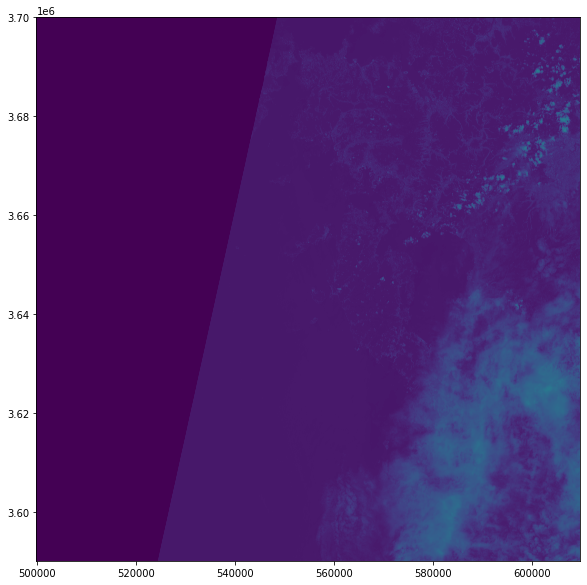

In [61]:
# 試しにband4の画像を描画
fig, ax = plt.subplots(1, figsize=(10, 10))
show(b4, ax=ax)
plt.show()

## GeoJsonで指定した範囲だけをTrue Colorの画像で表示

★★★時間かかるので注意

In [62]:
# 読み込んだ各バンドのデータを元にTiff画像を作成
with rio.open(str(objname) +'.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),3) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),1) 
    rgb.close()

In [65]:
RGB_tokyo =rio.open(str(objname) +'.tiff')
RGB_tokyo.crs

CRS.from_epsg(32652)

In [66]:
# データ取得時に作成したポリゴンデータを読み込み
nReserve_geo = gpd.read_file(str(objname) +'.geojson')
nReserve_geo

,geometry
0,"POLYGON ((130.10360 32.85811, 130.11184 32.594..."


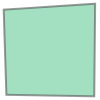

In [67]:
# 形を確認
nReserve_geo["geometry"][0]

In [68]:
# CRS変換
epsg = b4.crs
nReserve_proj = nReserve_geo.to_crs({'init': epsg})
nReserve_proj

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry
0,"POLYGON ((603261.057 3636097.011, 604338.495 3..."


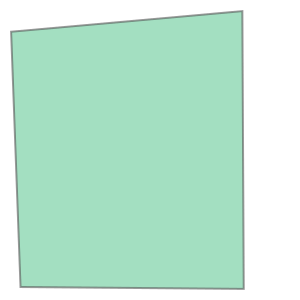

In [69]:
nReserve_proj["geometry"][0]

In [70]:
# Tiff画像をgeojsonデータをもとにマスク（切り出し）
with rio.open(str(objname) +'.tiff') as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [71]:
out_image

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

In [72]:
out_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 652,
 'height': 3178,
 'count': 3,
 'crs': CRS.from_epsg(32652),
 'transform': Affine(10.0, 0.0, 603260.0,
        0.0, -10.0, 3638460.0)}

In [73]:
# マスクしたデータを保存
with rasterio.open('Masked_' +str(objname) +'.tif', "w", **out_meta) as dest:
    dest.write(out_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


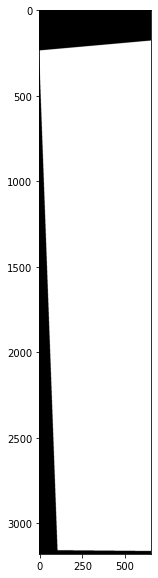

<function matplotlib.pyplot.show(close=None, block=None)>

In [74]:
msk = rio.open(r'Masked_' +str(objname) +'.tif')
fig, ax = plt.subplots(1, figsize=(10, 10))
show(msk.read([1,2,3]))
plt.show

### 見た目を人間の目でも理解できるように変換し、jpgファイルとして保存

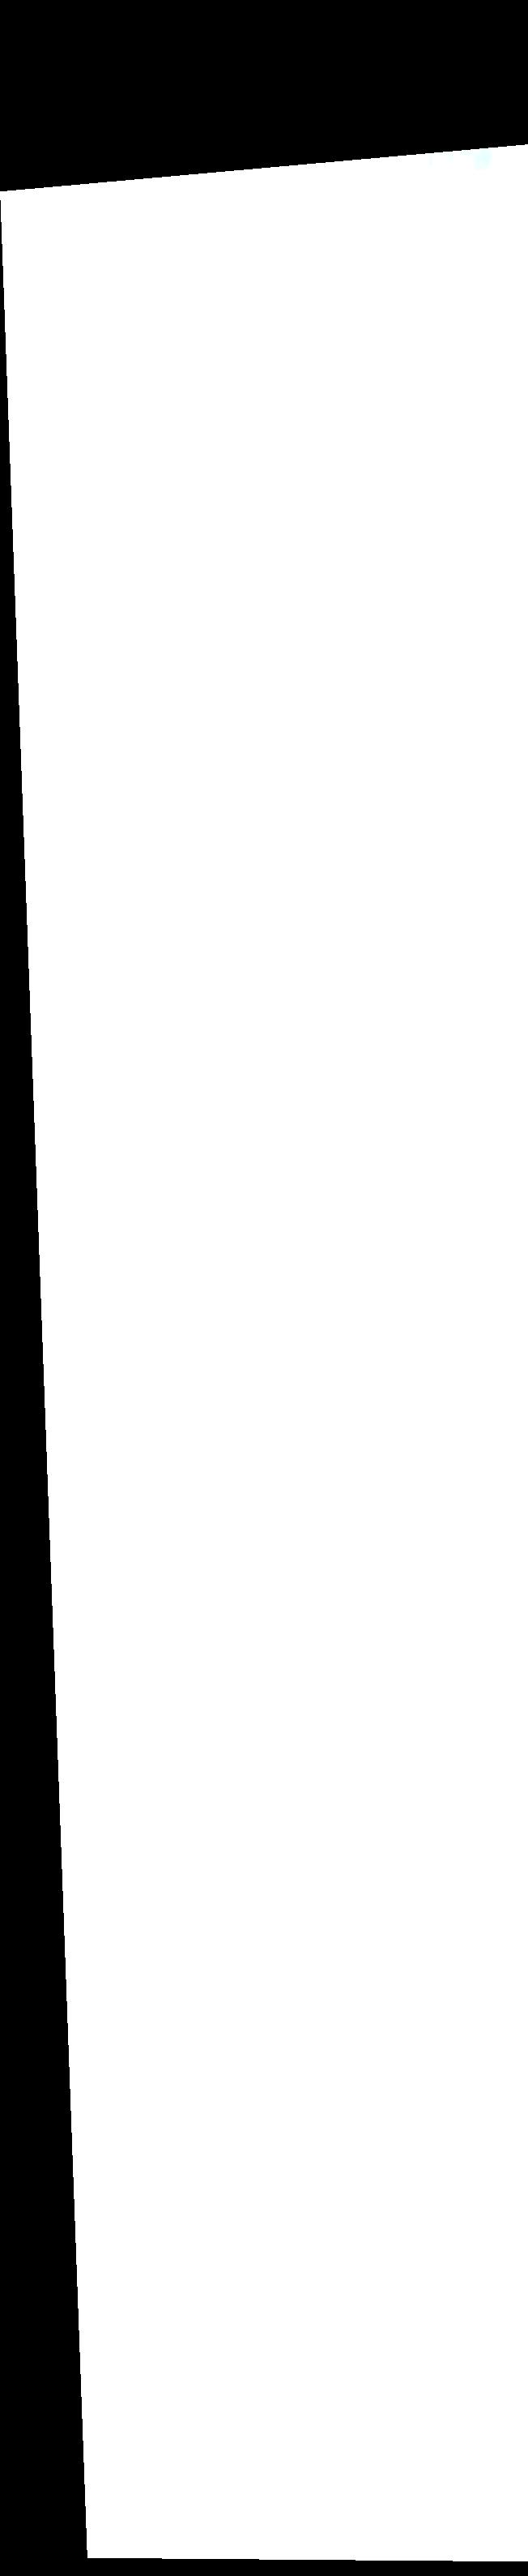

In [75]:
from osgeo import gdal

scale = '-scale 0 250 0 30'
options_list = [
    '-ot Byte',
    '-of JPEG',
    scale
] 
options_string = " ".join(options_list)

gdal.Translate('Masked_' +str(objname) +'.jpg',
               'Masked_' +str(objname) +'.tif',
               options=options_string)
from PIL import Image
im = Image.open('Masked_' +str(objname) +'.jpg')
im